## What percentage of users opened the email and what percentage clicked on the link within the email?

In [5]:
import pandas as pd

# Load your CSV files
email_table = pd.read_csv('email_table.csv')
email_opened_table = pd.read_csv('email_opened_table.csv')
link_clicked_table = pd.read_csv('link_clicked_table.csv')

# Total number of emails sent
total_emails = len(email_table)

# Total number of emails opened
emails_opened = len(email_opened_table)

# Total number of emails clicked
emails_clicked = len(link_clicked_table)

# Calculating the percentages
opened_percentage = (emails_opened / total_emails) * 100
clicked_percentage = (emails_clicked / total_emails) * 100

# Printing the results
print(f"Percentage of emails opened: {opened_percentage:.2f}%")
print(f"Percentage of emails with link clicked: {clicked_percentage:.2f}%")


Percentage of emails opened: 10.35%
Percentage of emails with link clicked: 2.12%


In [6]:
#combining dataset for predictive member 
#opened (1 = opened, 0 = not opened)
#clicked (1 = link clicked, 0 = not clicked) ← our prediction target

# Mark emails that were opened
email_table['opened'] = email_table['email_id'].isin(email_opened_table['email_id']).astype(int)

# Mark emails that had their link clicked
email_table['clicked'] = email_table['email_id'].isin(link_clicked_table['email_id']).astype(int)

# Drop email_id since it's just an identifier
email_data = email_table.drop(columns=['email_id'])

# Display the prepared data
email_data.head()   


,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,short_email,personalized,2,Sunday,US,5,0,0
1,long_email,personalized,12,Sunday,UK,2,1,1
2,long_email,personalized,11,Wednesday,US,2,0,0
3,short_email,generic,6,Monday,UK,1,0,0
4,long_email,generic,14,Monday,US,6,0,0


# Predictive model xgboost

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load data
email_table = pd.read_csv('email_table.csv')
email_opened_table = pd.read_csv('email_opened_table.csv')
link_clicked_table = pd.read_csv('link_clicked_table.csv')

# ---------- Enhanced Feature Engineering ----------

# Create click target
email_table['clicked'] = email_table['email_id'].isin(link_clicked_table['email_id']).astype(int)

# Create 'opened' feature (important signal)
email_table['opened'] = email_table['email_id'].isin(email_opened_table['email_id']).astype(int)

# Extract features from email_text (length might be predictive)
email_table['email_text_length'] = email_table['email_text'].str.len()

# Time-based features
email_table['is_weekend'] = (email_table['weekday'].isin(['Saturday', 'Sunday'])).astype(int)

# Group hours into meaningful time blocks
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

email_table['time_block'] = email_table['hour'].apply(time_of_day)

# User engagement ratio (if we have this data)
if 'user_id' in email_table.columns:
    # Calculate historical engagement rates per user
    user_stats = pd.DataFrame({
        'user_id': email_table['user_id'],
        'opened': email_table['opened'],
        'clicked': email_table['clicked']
    })
    
    user_open_rates = user_stats.groupby('user_id')['opened'].mean().reset_index()
    user_open_rates.columns = ['user_id', 'historical_open_rate']
    
    user_click_rates = user_stats.groupby('user_id')['clicked'].mean().reset_index()
    user_click_rates.columns = ['user_id', 'historical_click_rate']
    
    email_table = email_table.merge(user_open_rates, on='user_id', how='left')
    email_table = email_table.merge(user_click_rates, on='user_id', how='left')
    
    # Fill missing values for new users
    email_table['historical_open_rate'].fillna(email_table['historical_open_rate'].mean(), inplace=True)
    email_table['historical_click_rate'].fillna(email_table['historical_click_rate'].mean(), inplace=True)

# ---------- Exploratory Analysis ----------

# Check class imbalance
click_rate = email_table['clicked'].mean()
print(f"Click rate: {click_rate:.4f} ({email_table['clicked'].sum()} clicks out of {len(email_table)} emails)")

# Correlation with numerical features
if len(email_table.select_dtypes(include=['number'])) > 0:
    correlation_matrix = email_table.select_dtypes(include=['number']).corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.savefig('feature_correlation.png')
    plt.close()

# ---------- Feature Selection and Data Prep ----------

# Define feature groups
categorical_features = ['email_version', 'weekday', 'user_country', 'time_block']
numerical_features = ['hour', 'user_past_purchases', 'email_text_length']

# Add the engineered features if they exist
if 'historical_open_rate' in email_table.columns:
    numerical_features.extend(['historical_open_rate', 'historical_click_rate'])

# Include 'opened' as a very important predictor
if 'opened' in email_table.columns:
    numerical_features.append('opened')

# Add is_weekend
if 'is_weekend' in email_table.columns:
    numerical_features.append('is_weekend')

# Extract features and target
X = email_table.drop(['email_id', 'clicked'], axis=1)
y = email_table['clicked']

# Create a custom TF-IDF processor for email_text
text_transformer = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=100, stop_words='english', 
                              ngram_range=(1, 2), min_df=5))
])

# Define preprocessing steps
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('text', text_transformer, 'email_text')
], remainder='drop')

# ---------- Train-Test Split ----------

# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# ---------- Model Training and Hyperparameter Tuning ----------

# Define model pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, 
                                 eval_metric='logloss',
                                 random_state=42))
])

# Define hyperparameter grid
param_grid = {
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__max_depth': [3, 5, 7],
    'classifier__min_child_weight': [1, 3, 5],
    'classifier__subsample': [0.7, 0.8, 0.9],
    'classifier__colsample_bytree': [0.7, 0.8, 0.9],
    'classifier__n_estimators': [100, 200]
}

# Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search with cross-validation
grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

# Train model with grid search
grid_search.fit(X_train, y_train)

# Get best model
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

# ---------- Model Evaluation ----------

# Predictions
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

# Classification metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Precision-Recall AUC (better for imbalanced datasets)
average_precision = average_precision_score(y_test, y_pred_prob)
print(f"Average Precision Score: {average_precision:.4f}")

# Plot ROC curve
def plot_roc_curve(y_true, y_score):
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    plt.close()

plot_roc_curve(y_test, y_pred_prob)

# Plot Precision-Recall curve
def plot_precision_recall_curve(y_true, y_score):
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, 
             label=f'Precision-Recall curve (AP = {average_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.savefig('precision_recall_curve.png')
    plt.close()

plot_precision_recall_curve(y_test, y_pred_prob)

# ---------- Feature Importance Analysis ----------

# Extract feature names from the column transformer
def get_feature_names(column_transformer):
    output_features = []
    for name, pipe, features in column_transformer.transformers_:
        if name == 'text':
            # For text features we need to get the feature names from TfidfVectorizer
            output_features.extend([f'text_{i}' for i in range(pipe.named_steps['tfidf'].max_features)])
        elif name == 'cat':
            # For categorical features processed with OneHotEncoder
            cats = pipe.categories_
            for i, feature in enumerate(features):
                output_features.extend([f'{feature}_{c}' for c in cats[i]])
        elif name == 'num':
            # For numerical features
            output_features.extend(features)
    return output_features

# Get feature importances
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    feature_names = get_feature_names(best_model.named_steps['preprocessor'])
    importances = best_model.named_steps['classifier'].feature_importances_
    
    # Keep only the top 20 features
    indices = np.argsort(importances)[::-1][:20]
    top_importances = importances[indices]
    top_feature_names = [feature_names[i] if i < len(feature_names) else f'feature_{i}' for i in indices]
    
    plt.figure(figsize=(10, 8))
    plt.title('Feature Importances')
    plt.barh(range(len(top_importances)), top_importances, align='center')
    plt.yticks(range(len(top_importances)), top_feature_names)
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.close()

# ---------- Save Model for Production ----------

from joblib import dump
# Save the trained model
dump(best_model, 'email_click_prediction_model.joblib')

print("\nModel saved as 'email_click_prediction_model.joblib'")

# Example prediction function
def predict_click_probability(email_data):
    """
    Predict click probability for new emails
    
    Args:
        email_data: DataFrame with the same structure as training data
        
    Returns:
        Array of click probabilities
    """
    return best_model.predict_proba(email_data)[:, 1]

print("\nOptimization complete. The model is ready for production use.")

Click rate: 0.0212 (2119 clicks out of 100000 emails)
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


c:\Users\ASUS\anaconda3\envs\test\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:55:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.7}
Best CV score: 0.9580

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19576
           1       0.41      0.03      0.05       424

    accuracy                           0.98     20000
   macro avg       0.70      0.51      0.52     20000
weighted avg       0.97      0.98      0.97     20000

ROC-AUC Score: 0.9662
Average Precision Score: 0.3308

Model saved as 'email_click_prediction_model.joblib'

Optimization complete. The model is ready for production use.


# sengmantation Analysis 

In [ ]:
import pandas as pd

# Load your merged dataframe
# df = pd.read_csv('merged_email_data.csv')
df = email_data

# Example: Calculating overall open and click rates
overall_open_rate = df['opened'].mean() * 100
overall_click_rate = df['clicked'].mean() * 100

print(f"Overall Open Rate: {overall_open_rate:.2f}%")
print(f"Overall Click-Through Rate (CTR): {overall_click_rate:.2f}%\n")

# Function to analyze segments
def segment_analysis(df, column_name):
    segment_summary = df.groupby(column_name).agg(
        total_emails=('email_text', 'count'),
        open_rate=('opened', 'mean'),
        click_rate=('clicked', 'mean')
    ).reset_index()
    
    # Convert rates to percentages
    segment_summary['open_rate'] = segment_summary['open_rate'] * 100
    segment_summary['click_rate'] = segment_summary['click_rate'] * 100
    return segment_summary

# List of segmentation columns
segmentation_columns = [
    'email_text',
    'email_version',
    'weekday',
    'hour',
    'user_country',
    'user_past_purchases'
]

# Analyze each segment
for col in segmentation_columns:
    print(f"--- Analysis by {col} ---")
    result = segment_analysis(df, col)
    print(result.sort_values('click_rate', ascending=False).to_string(index=False))
    print("\n")


Overall Open Rate: 10.35%
Overall Click-Through Rate (CTR): 2.12%

--- Analysis by email_text ---
 email_text  total_emails  open_rate  click_rate
short_email         49724  11.585954    2.387177
 long_email         50276   9.117670    1.853767


--- Analysis by email_version ---
email_version  total_emails  open_rate  click_rate
 personalized         49791  12.775401    2.729409
      generic         50209   7.934832    1.513673


--- Analysis by weekday ---
  weekday  total_emails  open_rate  click_rate
Wednesday         14084  12.027833    2.761999
  Tuesday         14143  12.048363    2.488864
 Thursday         14277  11.844225    2.444491
   Monday         14363  11.606210    2.290608
 Saturday         14569   8.765186    1.784611
   Sunday         14387   8.764857    1.675123
   Friday         14177   7.413416    1.403682


--- Analysis by hour ---
 hour  total_emails  open_rate  click_rate
   23           145   8.275862    4.137931
   24            69  15.942029    2.898551
   1

# CTR uplifting

In [19]:
# Feature Engineering

# Create 'email_text_length'
df['email_text_length'] = df['email_text'].str.len()

# Create 'is_weekend' (whether the email was sent on a weekend)
df['is_weekend'] = df['weekday'].isin(['Saturday', 'Sunday']).astype(int)

# Create 'time_block' based on the 'hour'
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

df['time_block'] = df['hour'].apply(time_of_day)


In [20]:
X_full = df.drop(['clicked'], axis=1)  # Feature set
y_full = df['clicked']                # Target

# Predict probabilities for all emails (using the pre-trained model)
df['predicted_click_probability'] = best_model.predict_proba(X_full)[:, 1]


In [16]:
from joblib import load

# Load your model
best_model = load('email_click_prediction_model.joblib')


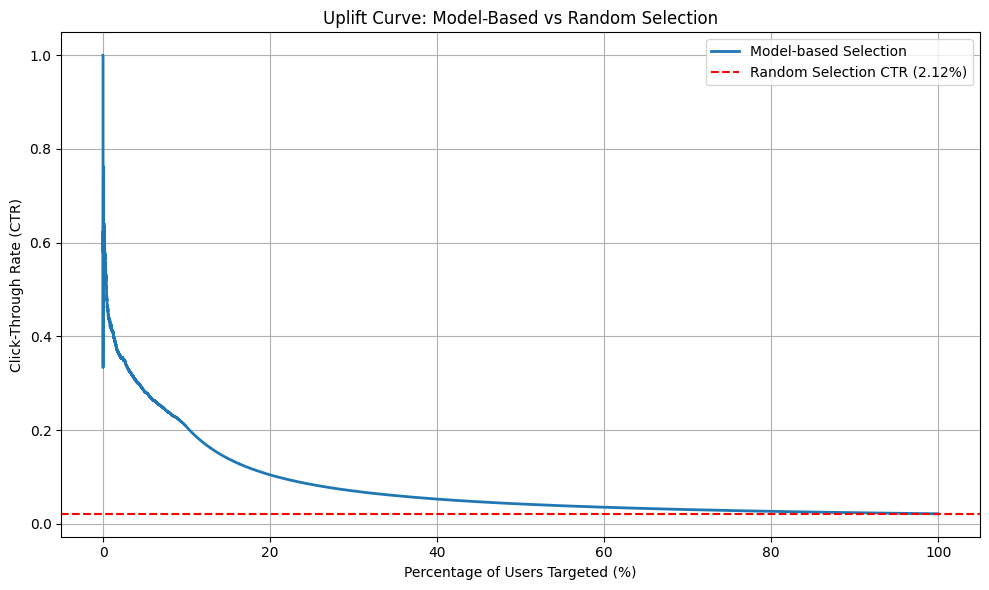

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sort users by predicted probability
df_sorted = df.sort_values('predicted_click_probability', ascending=False).reset_index(drop=True)

# Calculate cumulative CTR
df_sorted['cumulative_clicks'] = df_sorted['clicked'].cumsum()
df_sorted['emails_sent'] = np.arange(1, len(df_sorted) + 1)
df_sorted['cumulative_ctr'] = df_sorted['cumulative_clicks'] / df_sorted['emails_sent']

# Historical CTR (random baseline)
historical_ctr = df['clicked'].mean()

# Plot uplift curve
plt.figure(figsize=(10, 6))
plt.plot(df_sorted['emails_sent'] / len(df_sorted) * 100,  # % of users
         df_sorted['cumulative_ctr'], label='Model-based Selection', linewidth=2)

plt.axhline(y=historical_ctr, color='red', linestyle='--', label=f'Random Selection CTR ({historical_ctr:.2%})')

plt.xlabel('Percentage of Users Targeted (%)')
plt.ylabel('Click-Through Rate (CTR)')
plt.title('Uplift Curve: Model-Based vs Random Selection')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


CTR of Model-Based Selection (Top 20%): 0.1043
CTR of Random Selection (Historical): 0.0212


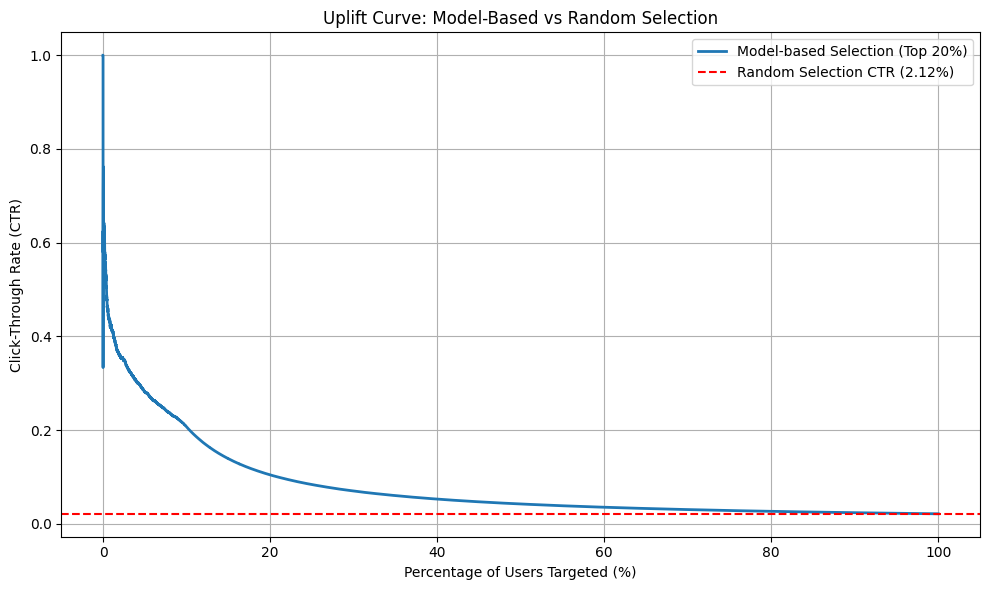

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is your data and best_model is already trained

# Step 1: Predict click probabilities for all emails
df['predicted_click_probability'] = best_model.predict_proba(df.drop(['clicked'], axis=1))[:, 1]

# Step 2: Sort users by predicted probability in descending order
df_sorted = df.sort_values('predicted_click_probability', ascending=False).reset_index(drop=True)

# Step 3: Select the top X% of users (e.g., top 20%)
X_percent = 20  # Choose percentage (e.g., 20 for top 20%)
top_x_percent = int(len(df_sorted) * (X_percent / 100))
df_top_x = df_sorted.iloc[:top_x_percent]

# Step 4: Calculate the CTR of the model-based selection
ctr_model_based = df_top_x['clicked'].mean()

# Step 5: Compare with the historical (random) CTR
ctr_random = df['clicked'].mean()

# Display results
print(f"CTR of Model-Based Selection (Top {X_percent}%): {ctr_model_based:.4f}")
print(f"CTR of Random Selection (Historical): {ctr_random:.4f}")

# Step 6: Plot the uplift curve
# Calculate cumulative CTR for the model-based selection
df_sorted['cumulative_clicks'] = df_sorted['clicked'].cumsum()
df_sorted['emails_sent'] = np.arange(1, len(df_sorted) + 1)
df_sorted['cumulative_ctr'] = df_sorted['cumulative_clicks'] / df_sorted['emails_sent']

# Plot the uplift curve
plt.figure(figsize=(10, 6))
plt.plot(df_sorted['emails_sent'] / len(df_sorted) * 100,  # % of users
         df_sorted['cumulative_ctr'], label=f'Model-based Selection (Top {X_percent}%)', linewidth=2)

# Plot historical CTR (random baseline)
plt.axhline(y=ctr_random, color='red', linestyle='--', label=f'Random Selection CTR ({ctr_random:.2%})')

# Labels and title
plt.xlabel('Percentage of Users Targeted (%)')
plt.ylabel('Click-Through Rate (CTR)')
plt.title('Uplift Curve: Model-Based vs Random Selection')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
